# **Import Library**

Bagian ini berfungsi untuk mengimpor berbagai *library* atau pustaka yang digunakan dalam pemrosesan data, visualisasi, penyeimbangan data, ekstraksi fitur teks, pembuatan model klasifikasi (*Random Forest* dan *Neural Network*), pembagian data latih-uji, serta penyimpanan model.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import randint
from imblearn.over_sampling import SMOTE

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split

import joblib

# **Data Loading**

Bagian ini berfungsi untuk memuat dan membersihkan data ulasan dari lima aspek (*attractions*, *amenities*, *access*, *price*, dan *no_aspect*) yang telah diekspor ke dalam file Excel. Setelah diekspor, selanjutnya setiap dataset dilakukan *cleaning* dari nilai kosong (NaN) agar siap digunakan dalam proses analisis dan pelatihan model.

In [ ]:
clean_attractions = pd.read_excel("data/clean_attractions.xlsx")
clean_attractions = clean_attractions.dropna()

clean_amenities = pd.read_excel("data/clean_amenities.xlsx")
clean_amenities = clean_amenities.dropna()

clean_access = pd.read_excel("data/clean_access.xlsx")
clean_access = clean_access.dropna()

clean_price = pd.read_excel("data/clean_price.xlsx")
clean_price = clean_price.dropna()

clean_no_aspect = pd.read_excel("data/clean_no_aspect.xlsx")
clean_no_aspect = clean_no_aspect.dropna()

# **Preprocessing Data**

## **Encoding Label Menjadi Kode Numerik**

Bagian ini berfungsi untuk mengubah label sentimen dari bentuk teks (“negative”, “neutral”, “positive”, “none”) menjadi angka (0, 1, 2, 3). Pengubahan ini diperlukan agar data bisa diproses oleh model machine learning yang hanya bisa membaca data dalam bentuk numerik.

In [ ]:
label = {
    "negative": 0,
    "neutral": 1,
    "positive": 2,
    "none": 3
}

clean_attractions["label"] = clean_attractions["label"].map(label)
clean_amenities["label"] = clean_amenities["label"].map(label)
clean_access["label"] = clean_access["label"].map(label)
clean_price["label"] = clean_price["label"].map(label)
clean_no_aspect["label"] = clean_no_aspect["label"].map(label)

## **Pengecekan Distribusi Label**

Selanjutnya dilakukan penghitungan jumlah data pada masing-masing label sentimen (negatif, netral, positif, none) untuk setiap aspek ulasan agar memudahkan kita melihat seberapa seimbang distribusi data di tiap aspek.

In [ ]:
distributions = {
    "attractions": clean_attractions["label"].value_counts(),
    "amenities": clean_amenities["label"].value_counts(),
    "access": clean_access["label"].value_counts(),
    "price": clean_price["label"].value_counts(),
    "no_aspect": clean_no_aspect["label"].value_counts(),
}

df_distribution = pd.DataFrame(distributions).fillna(0).astype(int)
print(df_distribution)

       attractions  amenities  access  price  no_aspect
label                                                  
0              309        227      34     27         57
1              216        154      32     18        513
2             2218        916     191    173        348
3              861       2308    3348   3387       2682


**Insight:**  
Berdasarkan grafik di atas, setiap label tidak memiliki distribusi yang merata. Review lebih banyak memiliki label positif dan review netral memiliki jumlah yang sangat sedikit. Oleh karena itu, terjadi data *imbalance* pada dataset dan harus ditangani agar menghasilkan model yang baik.

## **Feature Extraction**

Bagian ini berfungsi untuk memisahkan data ulasan (teks) dan label sentimennya untuk setiap aspek. `X_` berisi teks ulasan yang akan dianalisis, sedangkan `Y_` berisi label sentimen yang menjadi target untuk diprediksi oleh model.

In [ ]:
X_attractions = clean_attractions["final_text"]
Y_attractions = clean_attractions["label"]

X_amenities = clean_amenities["final_text"]
Y_amenities = clean_amenities["label"]

X_access = clean_access["final_text"]
Y_access = clean_access["label"]

X_price = clean_price["final_text"]
Y_price = clean_price["label"]

X_no_aspect = clean_no_aspect["final_text"]
Y_no_aspect = clean_no_aspect["label"]

## **TF-IDF**

Bagian ini berfungsi untuk mengubah teks ulasan menjadi angka menggunakan metode TF-IDF, supaya bisa dipahami oleh model machine learning. Fungsi `feature_extraction` akan menghasilkan data numerik (fitur) dan objek vectorizer-nya untuk setiap aspek ulasan.


In [ ]:
def feature_extraction(X):
    tfidf = TfidfVectorizer()
    X_tfidf = tfidf.fit_transform(X)

    return X_tfidf, tfidf

In [ ]:
X_attractions_tfidf, tfidf_attractions  = feature_extraction(X_attractions)
X_amenities_tfidf, tfidf_amenities = feature_extraction(X_amenities)
X_access_tfidf, tfidf_access = feature_extraction(X_access)
X_price_tfidf, tfidf_price = feature_extraction(X_price)
X_no_aspect_tfidf, tfidf_no_aspect = feature_extraction(X_no_aspect)

## **Penerapan SMOTE**

Karena terdapat ketidakseimbangan jumlah data antar label, maka untuk mengatasinya dengan menggunakan metode SMOTE (*Synthetic Minority Over-sampling Technique*). SMOTE menambahkan data sintetis pada label yang jumlahnya sedikit, sehingga model bisa belajar secara lebih seimbang dan akurat.

In [ ]:
def oversample_smote(X, Y):
    smote = SMOTE(random_state=42)
    X_smote, Y_smote = smote.fit_resample(X, Y)

    return X_smote, Y_smote

In [ ]:
X_attractions_smote, Y_attractions_smote = oversample_smote(X_attractions_tfidf, Y_attractions)
X_amenities_smote, Y_amenities_smote = oversample_smote(X_amenities_tfidf, Y_amenities)
X_access_smote, Y_access_smote = oversample_smote(X_access_tfidf, Y_access)
X_price_smote, Y_price_smote = oversample_smote(X_price_tfidf, Y_price)
X_no_aspect_smote, Y_no_aspect_smote = oversample_smote(X_no_aspect_tfidf, Y_no_aspect)

c:\Users\hp14s\anaconda3\envs\main-ds\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\hp14s\anaconda3\envs\main-ds\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\hp14s\anaconda3\envs\main-ds\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\hp14s\anaconda3\envs\main-ds\lib\s

## **Data Splitting**

Data dibagi menjadi 3 subset, yaitu 80% data training, 10% data validation, dan 10% data testing

In [ ]:
# Attractions
X_attractions_train, X_attractions_temp, Y_attractions_train, Y_attractions_temp = train_test_split(
    X_attractions_smote, Y_attractions_smote, test_size=0.3, random_state=42)
X_attractions_val, X_attractions_test, Y_attractions_val, Y_attractions_test = train_test_split(
    X_attractions_temp, Y_attractions_temp, test_size=0.5, random_state=42)

# Amenities
X_amenities_train, X_amenities_temp, Y_amenities_train, Y_amenities_temp = train_test_split(
    X_amenities_smote, Y_amenities_smote, test_size=0.3, random_state=42)
X_amenities_val, X_amenities_test, Y_amenities_val, Y_amenities_test = train_test_split(
    X_amenities_temp, Y_amenities_temp, test_size=0.5, random_state=42)

# Access
X_access_train, X_access_temp, Y_access_train, Y_access_temp = train_test_split(
    X_access_smote, Y_access_smote, test_size=0.3, random_state=42)
X_access_val, X_access_test, Y_access_val, Y_access_test = train_test_split(
    X_access_temp, Y_access_temp, test_size=0.5, random_state=42)

# Price
X_price_train, X_price_temp, Y_price_train, Y_price_temp = train_test_split(
    X_price_smote, Y_price_smote, test_size=0.3, random_state=42)
X_price_val, X_price_test, Y_price_val, Y_price_test = train_test_split(
    X_price_temp, Y_price_temp, test_size=0.5, random_state=42)

# No aspect
X_no_aspect_train, X_no_aspect_temp, Y_no_aspect_train, Y_no_aspect_temp = train_test_split(
    X_no_aspect_smote, Y_no_aspect_smote, test_size=0.3, random_state=42)
X_no_aspect_val, X_no_aspect_test, Y_no_aspect_val, Y_no_aspect_test = train_test_split(
    X_no_aspect_temp, Y_no_aspect_temp, test_size=0.5, random_state=42)

## **Label Encoding**

Bagian selanjutnya mengubah label sentimen pada dataset yang telah dilakukan SMOTE, yang berupa angka menjadi bentuk one-hot encoding, yaitu format vektor biner yang dibutuhkan untuk melatih model neural network dalam klasifikasi multi-kelas. Proses ini dilakukan untuk data latih, validasi, dan uji di setiap aspek ulasan.

In [ ]:
def label_encoding(Y_train, Y_val, Y_test):
    Y_train_encoded = to_categorical(Y_train)
    Y_val_encoded   = to_categorical(Y_val)
    Y_test_encoded  = to_categorical(Y_test)

    return Y_train_encoded, Y_val_encoded, Y_test_encoded

In [ ]:
Y_train_attractions_cat, Y_val_attractions_cat, Y_test_attractions_cat = label_encoding(Y_attractions_train, Y_attractions_val, Y_attractions_test)
Y_train_amenities_cat, Y_val_amenities_cat, Y_test_amenities_cat = label_encoding(Y_amenities_train, Y_amenities_val, Y_amenities_test)
Y_train_access_cat, Y_val_access_cat, Y_test_access_cat = label_encoding(Y_access_train, Y_access_val, Y_access_test)
Y_train_price_cat, Y_val_price_cat, Y_test_price_cat = label_encoding(Y_price_train, Y_price_val, Y_price_test)
Y_train_no_aspect_cat, Y_val_no_aspect_cat, Y_test_no_aspect_cat = label_encoding(Y_no_aspect_train, Y_no_aspect_val, Y_no_aspect_test)

# **Modeling**

Setelah melakukan preprocessing data, selanjutnya masuk ke tahap pemodelan dimana pada project ini akan menggunakan dua model yaitu Neural Network dan Random Forest Algorithm

## **Neural Network**

Model pertama yang akan dibangun yaitu Neurall Network (NN). Bagian ini berfungsi untuk membangun arsitektur model Neural Network (NN) untuk masing-masing aspek ulasan. Model terdiri dari beberapa lapisan Dense (fully connected) dengan aktivasi ReLU, dan lapisan output menggunakan softmax untuk klasifikasi multi-kelas. Fungsi `ModelCheckpoint` digunakan untuk menyimpan model terbaik selama pelatihan berdasarkan akurasi validasi tertinggi.


In [ ]:
embedding_dim = 64
num_classes = 3

def neural_network(model_name, X_train):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(4, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    checkpoint = ModelCheckpoint(
        f"models/nn_{model_name}.h5",
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    )

    return model, checkpoint

In [ ]:
model_attractions, checkpoint_attractions = neural_network("attractions", X_attractions_train)
model_amenities, checkpoint_amenities = neural_network("amenities", X_amenities_train)
model_access, checkpoint_access = neural_network("access", X_access_train)
model_price, checkpoint_price = neural_network("price", X_price_train)
model_no_aspect, checkpoint_no_aspect = neural_network("no_aspect", X_no_aspect_train)

c:\Users\hp14s\anaconda3\envs\main-ds\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### **Fungsi untuk Plot Learning Curve**

Bagian ini menampilkan fungsi untuk memvisualisasikan *learning curve* dari proses pelatihan model. Grafik menampilkan perubahan nilai *loss* dan *accuracy* untuk data pelatihan dan validasi di setiap epoch, sehingga memudahkan evaluasi kinerja dan deteksi overfitting atau underfitting.


In [ ]:
def plot_learning_curve(hist):
    history = hist.history

    # Plot Loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Learning Curve - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Learning Curve - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# **Random Forest**

Selanjutnya, dilakukan pemodelan menggunakan algoritma Random Forest sebagai pembanding terhadap model Neural Network. Pertama-tama, `param_dist` didefinisikan sebagai ruang parameter untuk pencarian *hyperparameter tuning* secara acak (meskipun belum digunakan dalam kode ini). Parameter tersebut mencakup jumlah pohon (`n_estimators`), kedalaman maksimum pohon (`max_depth`), jumlah minimal sampel untuk membagi node (`min_samples_split`), jumlah minimal sampel di daun (`min_samples_leaf`), metode pemilihan fitur terbaik (`max_features`), serta opsi *bootstrap*.

Kemudian, fungsi `random_forest()` dibuat untuk melatih model `RandomForestClassifier` dari *scikit-learn* menggunakan data latih yang diberikan. Model dilatih untuk masing-masing aspek: `attractions`, `amenities`, `access`, `price`, dan `no_aspect`, dengan memanggil fungsi tersebut secara terpisah untuk setiap data.

In [ ]:
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(5, 50),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

def random_forest(X_train, Y_train):
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train, Y_train)

    return rf

In [ ]:
rf_attractions = random_forest(X_attractions_train, Y_train_attractions_cat)
rf_amenities = random_forest(X_amenities_train, Y_train_amenities_cat)
rf_access = random_forest(X_access_train, Y_train_access_cat)
rf_price = random_forest(X_price_train, Y_train_price_cat)
rf_no_aspect = random_forest(X_no_aspect_train, Y_train_no_aspect_cat)

### **Attractions**

Setelah itu, pelatihan dilakukan juga pada model Neural Network untuk aspek *Attractions*. Model dilatih selama 20 *epoch* menggunakan data latih dan data validasi, serta menggunakan *callback* `ModelCheckpoint` agar hanya model terbaik yang disimpan.

In [ ]:
hist_attractions = model_attractions.fit(
    X_attractions_train, Y_train_attractions_cat,
    epochs=20,
    validation_data=(X_attractions_val, Y_val_attractions_cat),
    callbacks=[checkpoint_attractions]
)

Epoch 1/20
190/195 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5975 - loss: 1.0661
Epoch 1: val_accuracy improved from -inf to 0.90008, saving model to models/nn_attractions.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6021 - loss: 1.0551 - val_accuracy: 0.9001 - val_loss: 0.2625
Epoch 2/20
185/195 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9460 - loss: 0.1518
Epoch 2: val_accuracy improved from 0.90008 to 0.92938, saving model to models/nn_attractions.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9459 - loss: 0.1517 - val_accuracy: 0.9294 - val_loss: 0.1912
Epoch 3/20
186/195 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9843 - loss: 0.0566
Epoch 3: val_accuracy improved from 0.92938 to 0.94140, saving model to models/nn_attractions.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9842 - loss: 0.0568 - val_accuracy: 0.9414 - val_loss: 0.1751
Epoch 4/20
187/195 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9903 - loss: 0.0374
Epoch 4: val_accuracy did not improve from 0.94140
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9903 - loss: 0.0372 - val_accuracy: 0.9406 - val_loss: 0.1944
Epoch 5/20
185/195 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9935 - loss: 0.0241
Epoch 5: val_accuracy did not improve from 0.94140
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9936 - loss: 0.0240 - val_accuracy: 0.9339 - val_loss: 0.2296
Epoch 6/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9959 - loss: 0.0134
Epoch 6: val_accuracy did not improve from 0.94140
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9959 - loss: 0.0134 - val_accuracy: 0.9384 - val_loss: 0.2352
Epoch 7/20
191/195 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9951 - loss: 0.0133
Epoch 7: val_accuracy did not impro

### **Learning Curve**

Hasil proses pelatihan kemudian divisualisasikan dengan fungsi `plot_learning_curve()` untuk melihat perkembangan akurasi dan *loss* seiring waktu.

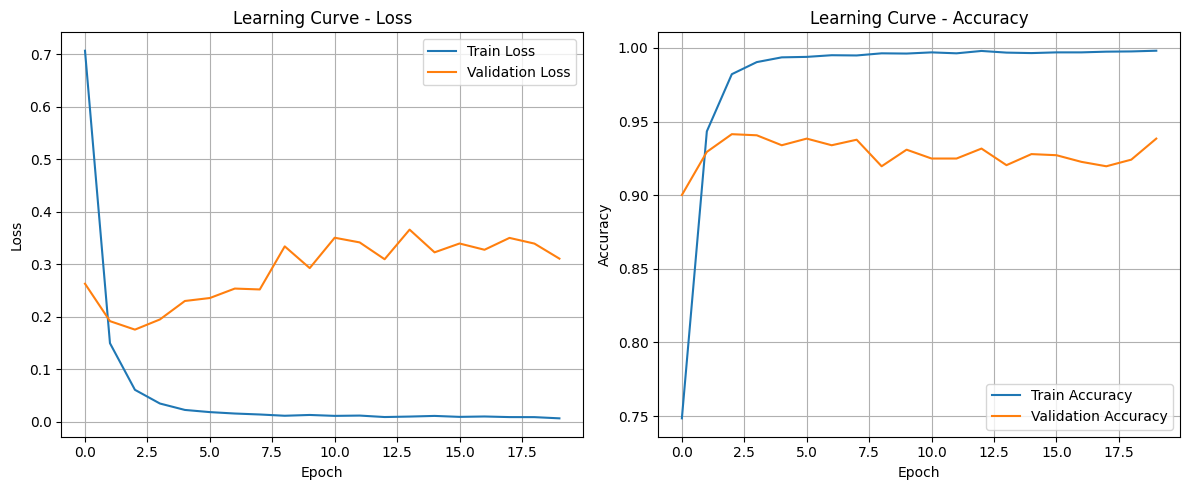

In [ ]:
plot_learning_curve(hist_attractions)

### **Amenities**

Setelah itu, pelatihan dilakukan juga pada model Neural Network untuk aspek *Amenities*. Model dilatih selama 20 *epoch* menggunakan data latih dan data validasi, serta menggunakan *callback* `ModelCheckpoint` agar hanya model terbaik yang disimpan.

In [ ]:
hist_amenities = model_amenities.fit(
    X_amenities_train, Y_train_amenities_cat,
    epochs=20,
    validation_data=(X_amenities_val, Y_val_amenities_cat),
    callbacks=[checkpoint_amenities]
)

Epoch 1/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6287 - loss: 0.9827
Epoch 1: val_accuracy improved from -inf to 0.93935, saving model to models/nn_amenities.h5


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6295 - loss: 0.9807 - val_accuracy: 0.9394 - val_loss: 0.1668
Epoch 2/20
199/202 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9802 - loss: 0.0766
Epoch 2: val_accuracy improved from 0.93935 to 0.94874, saving model to models/nn_amenities.h5


202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9802 - loss: 0.0764 - val_accuracy: 0.9487 - val_loss: 0.1420
Epoch 3/20
198/202 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9936 - loss: 0.0274
Epoch 3: val_accuracy improved from 0.94874 to 0.95451, saving model to models/nn_amenities.h5


202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9936 - loss: 0.0275 - val_accuracy: 0.9545 - val_loss: 0.1444
Epoch 4/20
192/202 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9975 - loss: 0.0128
Epoch 4: val_accuracy improved from 0.95451 to 0.95596, saving model to models/nn_amenities.h5


202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9975 - loss: 0.0129 - val_accuracy: 0.9560 - val_loss: 0.1480
Epoch 5/20
198/202 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9978 - loss: 0.0108
Epoch 5: val_accuracy improved from 0.95596 to 0.95884, saving model to models/nn_amenities.h5


202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9978 - loss: 0.0108 - val_accuracy: 0.9588 - val_loss: 0.1690
Epoch 6/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9986 - loss: 0.0055
Epoch 6: val_accuracy did not improve from 0.95884
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9986 - loss: 0.0055 - val_accuracy: 0.9495 - val_loss: 0.1988
Epoch 7/20
191/202 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9986 - loss: 0.0054
Epoch 7: val_accuracy did not improve from 0.95884
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9987 - loss: 0.0053 - val_accuracy: 0.9502 - val_loss: 0.2090
Epoch 8/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9998 - loss: 0.0019
Epoch 8: val_accuracy did not improve from 0.95884
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9998 - loss: 0.0019 - val_accuracy: 0.9458 - val_loss: 0.2351
Epoch 9/20
198/202 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9992 - loss: 0.0024
Epoch 9: val_accuracy did not impro

202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9999 - loss: 3.1157e-04 - val_accuracy: 0.9610 - val_loss: 0.2399
Epoch 16/20
194/202 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9984 - loss: 0.0056
Epoch 16: val_accuracy did not improve from 0.96101
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9984 - loss: 0.0056 - val_accuracy: 0.9372 - val_loss: 0.3614
Epoch 17/20
194/202 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9984 - loss: 0.0087
Epoch 17: val_accuracy did not improve from 0.96101
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9984 - loss: 0.0084 - val_accuracy: 0.9480 - val_loss: 0.2672
Epoch 18/20
192/202 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9998 - loss: 6.2378e-04
Epoch 18: val_accuracy did not improve from 0.96101
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9998 - loss: 6.8116e-04 - val_accuracy: 0.9545 - val_loss: 0.2422
Epoch 19/20
196/202 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9996 - loss: 0.0014
Epoch 19: val_ac

### **Learning Curve**

Hasil proses pelatihan kemudian divisualisasikan dengan fungsi `plot_learning_curve()` untuk melihat perkembangan akurasi dan *loss* seiring waktu.

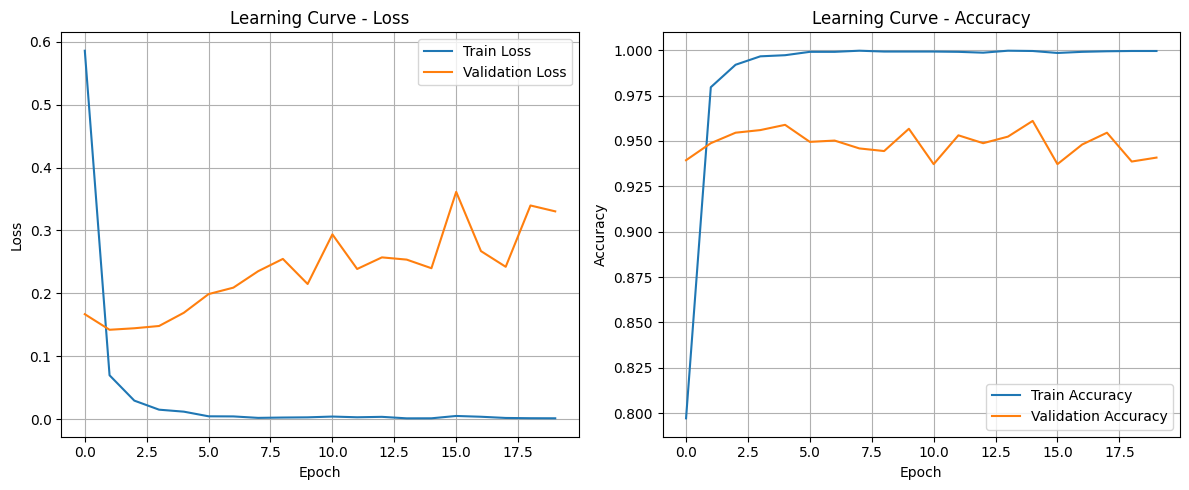

In [ ]:
plot_learning_curve(hist_amenities)

### **Access**

Setelah itu, pelatihan dilakukan juga pada model Neural Network untuk aspek *Access*. Model dilatih selama 20 *epoch* menggunakan data latih dan data validasi, serta menggunakan *callback* `ModelCheckpoint` agar hanya model terbaik yang disimpan.

In [ ]:
hist_access = model_access.fit(
    X_access_train, Y_train_access_cat,
    epochs=20,
    validation_data=(X_access_val, Y_val_access_cat),
    callbacks=[checkpoint_access]
)

Epoch 1/20
285/293 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8427 - loss: 0.6346
Epoch 1: val_accuracy improved from -inf to 0.99552, saving model to models/nn_access.h5


293/293 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8460 - loss: 0.6228 - val_accuracy: 0.9955 - val_loss: 0.0137
Epoch 2/20
291/293 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9990 - loss: 0.0043
Epoch 2: val_accuracy did not improve from 0.99552
293/293 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9990 - loss: 0.0043 - val_accuracy: 0.9935 - val_loss: 0.0204
Epoch 3/20
285/293 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9999 - loss: 0.0012
Epoch 3: val_accuracy improved from 0.99552 to 0.99602, saving model to models/nn_access.h5


293/293 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9999 - loss: 0.0012 - val_accuracy: 0.9960 - val_loss: 0.0088
Epoch 4/20
291/293 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.2611e-04
Epoch 4: val_accuracy did not improve from 0.99602
293/293 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 1.0000 - loss: 3.2544e-04 - val_accuracy: 0.9960 - val_loss: 0.0086
Epoch 5/20
292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5394e-04
Epoch 5: val_accuracy improved from 0.99602 to 0.99652, saving model to models/nn_access.h5


293/293 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 1.0000 - loss: 1.5385e-04 - val_accuracy: 0.9965 - val_loss: 0.0082
Epoch 6/20
288/293 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 9.1186e-05
Epoch 6: val_accuracy did not improve from 0.99652
293/293 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 1.0000 - loss: 9.1172e-05 - val_accuracy: 0.9965 - val_loss: 0.0089
Epoch 7/20
284/293 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 6.9424e-05
Epoch 7: val_accuracy did not improve from 0.99652
293/293 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 1.0000 - loss: 6.9181e-05 - val_accuracy: 0.9965 - val_loss: 0.0091
Epoch 8/20
292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 4.5262e-05
Epoch 8: val_accuracy improved from 0.99652 to 0.99701, saving model to models/nn_access.h5


293/293 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 1.0000 - loss: 4.5271e-05 - val_accuracy: 0.9970 - val_loss: 0.0079
Epoch 9/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.7372e-05
Epoch 9: val_accuracy did not improve from 0.99701
293/293 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 1.0000 - loss: 3.7363e-05 - val_accuracy: 0.9970 - val_loss: 0.0085
Epoch 10/20
291/293 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.5615e-05
Epoch 10: val_accuracy did not improve from 0.99701
293/293 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 1.0000 - loss: 2.5619e-05 - val_accuracy: 0.9970 - val_loss: 0.0085
Epoch 11/20
291/293 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 2.1032e-05
Epoch 11: val_accuracy did not improve from 0.99701
293/293 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 1.0000 - loss: 2.1029e-05 - val_accuracy: 0.9970 - val_loss: 0.0083
Epoch 12/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.6392e

293/293 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 1.0000 - loss: 7.7855e-06 - val_accuracy: 0.9975 - val_loss: 0.0092
Epoch 16/20
291/293 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 6.5101e-06
Epoch 16: val_accuracy did not improve from 0.99751
293/293 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 1.0000 - loss: 6.5134e-06 - val_accuracy: 0.9970 - val_loss: 0.0099
Epoch 17/20
290/293 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 5.8499e-06
Epoch 17: val_accuracy did not improve from 0.99751
293/293 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 1.0000 - loss: 5.8457e-06 - val_accuracy: 0.9975 - val_loss: 0.0098
Epoch 18/20
291/293 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.8924e-06
Epoch 18: val_accuracy did not improve from 0.99751
293/293 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 1.0000 - loss: 3.9002e-06 - val_accuracy: 0.9975 - val_loss: 0.0098
Epoch 19/20
291/293 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.4462e

### **Learning Curve**

Hasil proses pelatihan kemudian divisualisasikan dengan fungsi `plot_learning_curve()` untuk melihat perkembangan akurasi dan *loss* seiring waktu.

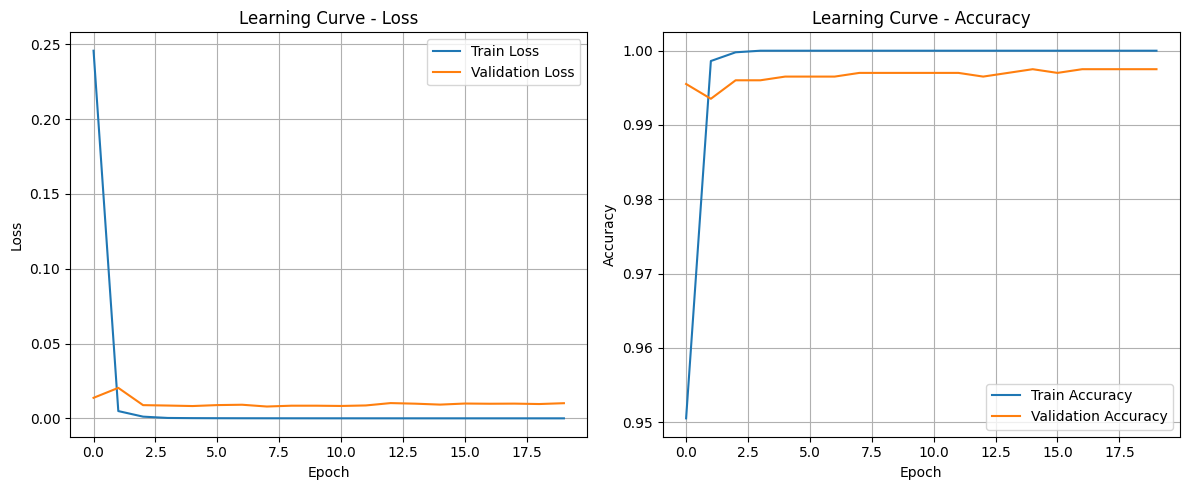

In [ ]:
plot_learning_curve(hist_access)

### **Price**

Setelah itu, pelatihan dilakukan juga pada model Neural Network untuk aspek *Price*. Model dilatih selama 20 *epoch* menggunakan data latih dan data validasi, serta menggunakan *callback* `ModelCheckpoint` agar hanya model terbaik yang disimpan.

In [ ]:
hist_price = model_price.fit(
    X_price_train, Y_train_price_cat,
    epochs=20,
    validation_data=(X_price_val, Y_val_price_cat),
    callbacks=[checkpoint_price]
)

Epoch 1/20
292/297 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8815 - loss: 0.5865
Epoch 1: val_accuracy improved from -inf to 0.99803, saving model to models/nn_price.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8832 - loss: 0.5790 - val_accuracy: 0.9980 - val_loss: 0.0084
Epoch 2/20
292/297 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9999 - loss: 0.0015
Epoch 2: val_accuracy improved from 0.99803 to 0.99852, saving model to models/nn_price.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9999 - loss: 0.0015 - val_accuracy: 0.9985 - val_loss: 0.0029
Epoch 3/20
287/297 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.2441e-04
Epoch 3: val_accuracy did not improve from 0.99852
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 1.0000 - loss: 2.3048e-04 - val_accuracy: 0.9985 - val_loss: 0.0054
Epoch 4/20
287/297 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.2683e-04
Epoch 4: val_accuracy did not improve from 0.99852
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 1.0000 - loss: 3.1961e-04 - val_accuracy: 0.9985 - val_loss: 0.0045
Epoch 5/20
290/297 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 5.3622e-05
Epoch 5: val_accuracy did not improve from 0.99852
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 1.0000 - loss: 5.3424e-05 - val_accuracy: 0.9985 - val_loss: 0.0047
Epoch 6/20
293/297 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.5235e-05
Epoch 6

### **Learning Curve**

Hasil proses pelatihan kemudian divisualisasikan dengan fungsi `plot_learning_curve()` untuk melihat perkembangan akurasi dan *loss* seiring waktu.

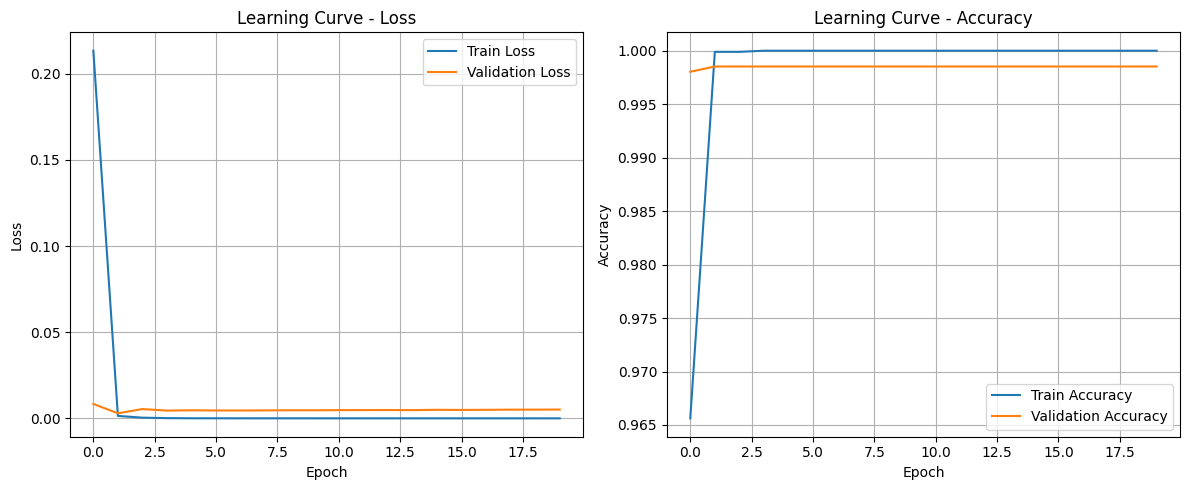

In [ ]:
plot_learning_curve(hist_price)

### **No Aspect**

Setelah itu, pelatihan dilakukan juga pada model Neural Network untuk aspek *No Aspect*. Model dilatih selama 20 *epoch* menggunakan data latih dan data validasi, serta menggunakan *callback* `ModelCheckpoint` agar hanya model terbaik yang disimpan.

In [ ]:
hist_no_aspect = model_no_aspect.fit(
    X_no_aspect_train, Y_train_no_aspect_cat,
    epochs=20,
    validation_data=(X_no_aspect_val, Y_val_no_aspect_cat),
    callbacks=[checkpoint_no_aspect]
)

Epoch 1/20
229/235 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6632 - loss: 0.9481
Epoch 1: val_accuracy improved from -inf to 0.92542, saving model to models/nn_no_aspect.h5


235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6677 - loss: 0.9370 - val_accuracy: 0.9254 - val_loss: 0.2123
Epoch 2/20
231/235 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9737 - loss: 0.0856
Epoch 2: val_accuracy improved from 0.92542 to 0.95836, saving model to models/nn_no_aspect.h5


235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9736 - loss: 0.0856 - val_accuracy: 0.9584 - val_loss: 0.1298
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9871 - loss: 0.0449
Epoch 3: val_accuracy did not improve from 0.95836
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9871 - loss: 0.0449 - val_accuracy: 0.9466 - val_loss: 0.1926
Epoch 4/20
232/235 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9916 - loss: 0.0338
Epoch 4: val_accuracy did not improve from 0.95836
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9916 - loss: 0.0337 - val_accuracy: 0.9490 - val_loss: 0.1668
Epoch 5/20
230/235 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9944 - loss: 0.0188
Epoch 5: val_accuracy did not improve from 0.95836
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9943 - loss: 0.0188 - val_accuracy: 0.9584 - val_loss: 0.1720
Epoch 6/20
231/235 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9967 - loss: 0.0148
Epoch 6: val_accuracy did not i

235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9952 - loss: 0.0136 - val_accuracy: 0.9608 - val_loss: 0.1767
Epoch 12/20
229/235 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9977 - loss: 0.0092
Epoch 12: val_accuracy did not improve from 0.96085
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9977 - loss: 0.0092 - val_accuracy: 0.9378 - val_loss: 0.3167
Epoch 13/20
233/235 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9961 - loss: 0.0145
Epoch 13: val_accuracy did not improve from 0.96085
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9961 - loss: 0.0144 - val_accuracy: 0.9459 - val_loss: 0.2863
Epoch 14/20
230/235 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9964 - loss: 0.0114
Epoch 14: val_accuracy did not improve from 0.96085
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9964 - loss: 0.0115 - val_accuracy: 0.9397 - val_loss: 0.2919
Epoch 15/20
232/235 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9971 - loss: 0.0101
Epoch 15: val_accuracy di

### **Learning Curve**

Hasil proses pelatihan kemudian divisualisasikan dengan fungsi `plot_learning_curve()` untuk melihat perkembangan akurasi dan *loss* seiring waktu.

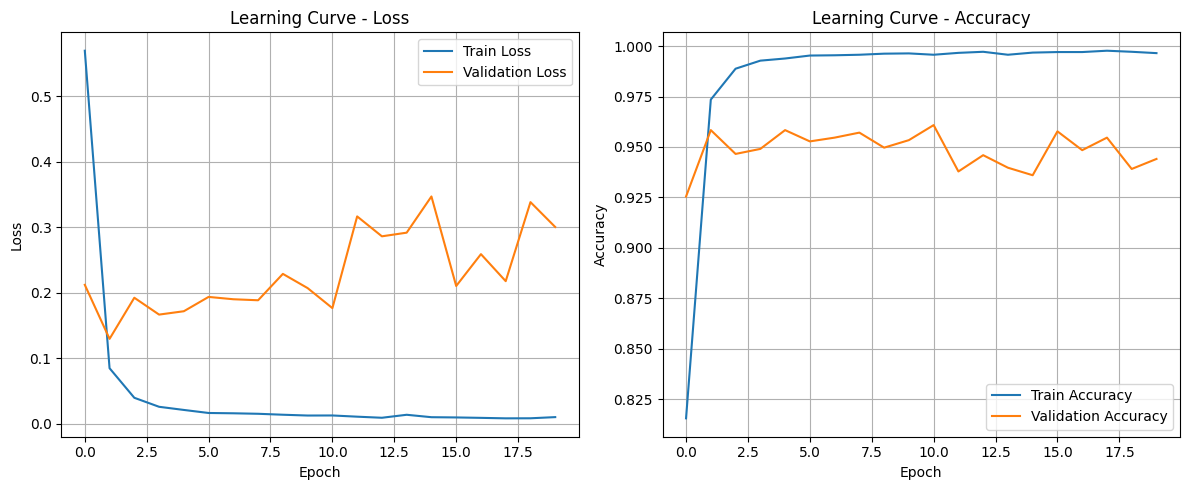

In [ ]:
plot_learning_curve(hist_no_aspect)

## **Evaluation**

Section kode ini berfungsi untuk mengevaluasi performa dua model klasifikasi, yaitu Neural Network dan Random Forest, berdasarkan metrik-metrik evaluasi umum seperti akurasi, precision, recall, dan F1-score pada data latih dan data uji.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

def evaluate_model(model_nn, model_rf, X_train, Y_train, X_test, Y_test):
    # --- Neural Network ---
    # Evaluasi langsung untuk akurasi dan loss
    train_loss_nn, train_accuracy_nn = model_nn.evaluate(X_train, Y_train, verbose=0)
    test_loss_nn, test_accuracy_nn = model_nn.evaluate(X_test, Y_test, verbose=0)

    # Prediksi probabilitas dari NN
    Y_train_pred_prob_nn = model_nn.predict(X_train)
    Y_test_pred_prob_nn = model_nn.predict(X_test)

    # Konversi ke kelas
    if Y_train_pred_prob_nn.shape[-1] > 1:
        Y_train_pred_nn = np.argmax(Y_train_pred_prob_nn, axis=1)
        Y_test_pred_nn = np.argmax(Y_test_pred_prob_nn, axis=1)
    else:
        Y_train_pred_nn = (Y_train_pred_prob_nn > 0.5).astype(int).flatten()
        Y_test_pred_nn = (Y_test_pred_prob_nn > 0.5).astype(int).flatten()

    if Y_train.ndim > 1 and Y_train.shape[-1] > 1:
        Y_train_labels = np.argmax(Y_train, axis=1)
        Y_test_labels = np.argmax(Y_test, axis=1)
    else:
        Y_train_labels = Y_train
        Y_test_labels = Y_test

    precision_nn = precision_score(Y_test_labels, Y_test_pred_nn, average='weighted', zero_division=0)
    recall_nn = recall_score(Y_test_labels, Y_test_pred_nn, average='weighted', zero_division=0)
    f1_nn = f1_score(Y_test_labels, Y_test_pred_nn, average='weighted', zero_division=0)

    # --- Random Forest ---
    Y_train_pred_rf = model_rf.predict(X_train)
    Y_test_pred_rf = model_rf.predict(X_test)

    train_accuracy_rf = accuracy_score(Y_train, Y_train_pred_rf)
    test_accuracy_rf = accuracy_score(Y_test, Y_test_pred_rf)

    precision_rf = precision_score(Y_test, Y_test_pred_rf, average='weighted', zero_division=0)
    recall_rf = recall_score(Y_test, Y_test_pred_rf, average='weighted', zero_division=0)
    f1_rf = f1_score(Y_test, Y_test_pred_rf, average='weighted', zero_division=0)

    return {
        # Neural Network
        'train_accuracy_nn': train_accuracy_nn,
        'test_accuracy_nn': test_accuracy_nn,
        'precision_nn': precision_nn,
        'recall_nn': recall_nn,
        'f1_nn': f1_nn,

        # Random Forest
        'train_accuracy_rf': train_accuracy_rf,
        'test_accuracy_rf': test_accuracy_rf,
        'precision_rf': precision_rf,
        'recall_rf': recall_rf,
        'f1_rf': f1_rf
    }


### **Attractions**

In [ ]:
eval_attractions = evaluate_model(
    model_attractions,
    rf_attractions,
    X_attractions_train,
    Y_train_attractions_cat,
    X_attractions_test,
    Y_test_attractions_cat
)

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
for key, value in eval_attractions.items():
    print(f"{key}: {value:.4f}")

train_accuracy_nn: 0.9958
test_accuracy_nn: 0.9444
precision_nn: 0.9455
recall_nn: 0.9444
f1_nn: 0.9437
train_accuracy_rf: 0.9987
test_accuracy_rf: 0.8655
precision_rf: 0.9463
recall_rf: 0.8655
f1_rf: 0.8998


**Insight:**

- NN unggul signifikan dalam akurasi dan f1-score dibanding RF.

- Selisih test accuracy cukup besar (~8%) → menunjukkan NN lebih andal dan generalizable untuk klasifikasi aspek attractions.



### **Amenities**

In [ ]:
eval_amenities = evaluate_model(
    model_amenities,
    rf_amenities,
    X_amenities_train,
    Y_train_amenities_cat,
    X_amenities_test,
    Y_test_amenities_cat
)

202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
for key, value in eval_amenities.items():
    print(f"{key}: {value:.4f}")

train_accuracy_nn: 0.9997
test_accuracy_nn: 0.9444
precision_nn: 0.9461
recall_nn: 0.9444
f1_nn: 0.9435
train_accuracy_rf: 0.9998
test_accuracy_rf: 0.9061
precision_rf: 0.9564
recall_rf: 0.9061
f1_rf: 0.9302


**Insight**:

- Kedua model menunjukkan performa sangat baik, namun NN tetap unggul secara keseluruhan.

- RF memiliki precision tinggi (0.9564), artinya prediksi RF lebih “yakin” tapi tidak seimbang dibanding NN.

- Selisih metrik menunjukkan bahwa NN lebih konsisten.

### **Access**

In [ ]:
eval_access = evaluate_model(
    model_access,
    rf_access,
    X_access_train,
    Y_train_access_cat,
    X_access_test,
    Y_test_access_cat
)

293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
for key, value in eval_access.items():
    print(f"{key}: {value:.4f}")

train_accuracy_nn: 1.0000
test_accuracy_nn: 0.9970
precision_nn: 0.9970
recall_nn: 0.9970
f1_nn: 0.9970
train_accuracy_rf: 1.0000
test_accuracy_rf: 0.9915
precision_rf: 0.9955
recall_rf: 0.9915
f1_rf: 0.9935


**Insight**:

- Kedua model sangat unggul — hampir sempurna.

- Selisih antar metrik sangat kecil (<1%) menunjukkan bahwa baik NN maupun RF cocok digunakan.

- Ini bisa menandakan bahwa fitur pada aspek access sangat informatif dan mudah dipelajari oleh kedua model.

### **Price**

In [ ]:
eval_price = evaluate_model(
    model_price,
    rf_price,
    X_price_train,
    Y_train_price_cat,
    X_price_test,
    Y_test_price_cat
)

297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
for key, value in eval_price.items():
    print(f"{key}: {value:.4f}")

train_accuracy_nn: 1.0000
test_accuracy_nn: 0.9995
precision_nn: 0.9995
recall_nn: 0.9995
f1_nn: 0.9995
train_accuracy_rf: 1.0000
test_accuracy_rf: 0.9941
precision_rf: 0.9956
recall_rf: 0.9941
f1_rf: 0.9948


**Insight**:

- Kinerja dari kedua model sangat bagus, dengan selisih nyaris tidak signifikan.

- Kemungkinan besar aspek price memiliki pola yang sangat jelas dan mudah dipelajari oleh algoritma.

### **No Aspect**

In [ ]:
eval_no_aspect = evaluate_model(
    model_no_aspect,
    rf_no_aspect,
    X_no_aspect_train,
    Y_train_no_aspect_cat,
    X_no_aspect_test,
    Y_test_no_aspect_cat
)

235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
for key, value in eval_no_aspect.items():
    print(f"{key}: {value:.4f}")

train_accuracy_nn: 0.9980
test_accuracy_nn: 0.9398
precision_nn: 0.9442
recall_nn: 0.9398
f1_nn: 0.9379
train_accuracy_rf: 0.9987
test_accuracy_rf: 0.9143
precision_rf: 0.9759
recall_rf: 0.9143
f1_rf: 0.9424


**Insight**:

- Di aspek ini, Random Forest unggul tipis pada f1-score, meski akurasi sedikit lebih rendah.

- Precision RF sangat tinggi (0.9759), artinya prediksinya sangat “hati-hati” namun akurat ketika benar.

- Ini menunjukkan bahwa RF mampu mengklasifikasikan dengan baik meskipun bukan model terbaik secara keseluruhan.

- Neural Network tetap seimbang dan stabil.

**Kesimpulan keseluruhan :**

Berdasarkan hasil evaluasi pada kelima aspek, model **Neural Network (NN)** secara umum dipilih sebagai model akhir karena menunjukkan performa yang lebih stabil dan akurat pada sebagian besar aspek, terutama *attractions*, *amenities*, dan *no aspect*, di mana Random Forest (RF) cenderung mengalami overfitting. Pada aspek *access* dan *price*, kedua model menunjukkan performa yang hampir sempurna, namun NN tetap menjadi pilihan utama karena konsistensinya di seluruh aspek. Dengan demikian, model Neural Network dipilih sebagai model akhir untuk klasifikasi sentimen berbasis aspek dalam proyek ini.


# **Simpan Model**

Bagian ini digunakan untuk **menyimpan model dan TF-IDF vectorizer** ke dalam file:

* **TF-IDF** disimpan dalam format `.pkl`
* **Model Random Forest** disimpan dalam format `.joblib`

Tujuannya agar bisa digunakan kembali tanpa perlu dilatih ulang.


## **TF-IDF**

In [ ]:
joblib.dump(tfidf_attractions, "models/tfidf_attractions.pkl")
joblib.dump(tfidf_amenities, "models/tfidf_amenities.pkl")
joblib.dump(tfidf_access, "models/tfidf_access.pkl")
joblib.dump(tfidf_price, "models/tfidf_price.pkl")
joblib.dump(tfidf_no_aspect, "models/tfidf_no_aspect.pkl")

['models/tfidf_no_aspect.pkl']

## **Random Forest**

In [ ]:
joblib.dump(rf_attractions, "models/rf_attractions.joblib")
joblib.dump(rf_amenities, "models/rf_amenities.joblib")
joblib.dump(rf_access, "models/rf_access.joblib")
joblib.dump(rf_price, "models/rf_price.joblib")
joblib.dump(rf_no_aspect, "models/rf_no_aspect.joblib")

['models/rf_no_aspect.joblib']